# Object masks from prompts with SAM2 and OpenVINO

<div class="alert alert-block alert-danger"> <b>Important note:</b> This notebook requires python >= 3.10. Please make sure that your environment fulfill to this requirement before running it </div>




### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/sam2-video-segmentation/segment-anything-2-video.ipynb" />


#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load the SAM2 PyTorch model](#Load-the-SAM2-PyTorch-model)
- [Convert Model to OpenVINO IR](#Convert-Model-to-OpenVINO-IR)
    - [Image Encoder Model](#Image-Encoder-Model)
    - [Mask Prediction Model](#Mask-Prediction-Model)
    - [Memory Encoder Model](#Memory-Encoder-Model)
    - [Memory Attention Model](#Memory-Attention-Model)
    - [Infer video prediction model in OpenVINO IR format](#Infer-video-prediction-model-in-OpenVINO-IR-format)
- [Prepare data](#Prepare-data)
    - [Example with points](#Example-with-points)
    - [Example with box](#Example-with-box)
    - [Run Interactive For Video Segmentation with Gradio](#Run-Interactive-For-Video-Segmentation-with-Gradio)



Segmentation - identifying which image pixels belong to an object - is a core task in computer vision and is used in a broad array of applications, from analyzing scientific imagery to editing photos. But creating an accurate segmentation model for specific tasks typically requires highly specialized work by technical experts with access to AI training infrastructure and large volumes of carefully annotated in-domain data. Reducing the need for task-specific modeling expertise, training compute, and custom data annotation for image segmentation is the main goal of the Segment Anything project.

[Segment Anything Model 2 (SAM 2)](https://ai.meta.com/sam2/) is a foundation model towards solving promptable visual segmentation in images and videos. It extend SAM to video by considering images as a video with a single frame. The SAM 2 model extends the promptable capability of SAM to the video domain by adding a per session memory module that captures information about the target object in the video.  This allows SAM 2 to track the selected object throughout all video frames, even if the object temporarily disappears from view, as the model has context of the object from previous frames. SAM 2 also supports the ability to make corrections in the mask prediction based on additional prompts on any frame. SAM 2’s streaming architecture—which processes video frames one at a time—is also a natural generalization of SAM to the video domain. When SAM 2 is applied to images, the memory module is empty and the model behaves like SAM. 

The model design is a simple transformer architecture with streaming memory for real-time video processing. The model is built a model-in-the-loop data engine, which improves model and data via user interaction, to collect SA-V dataset, the largest video segmentation dataset to date. SAM 2 provides strong performance across a wide range of tasks and visual domains.
This notebook shows an example of how to convert and use Segment Anything Model 2 in OpenVINO format, allowing it to run on a variety of platforms that support an OpenVINO.

The diagram below demonstrates the SAM 2 architecture. For a given frame, the segmentation prediction is conditioned on the current prompt and/or on previously observed memories. Videos are processed in a streaming fashion with frames being consumed one at a time by the image encoder, and cross-attended to memories of the target object from previous frames. The mask decoder, which optionally also takes input prompts, predicts the segmentation mask for that frame. Finally, a memory encoder transforms the prediction and image encoder embeddings (not shown in the figure) for use in future frames

![model_diagram](https://raw.githubusercontent.com/facebookresearch/segment-anything-2/main/assets/model_diagram.png)


More details about approach can be found in the [paper](https://ai.meta.com/research/publications/sam-2-segment-anything-in-images-and-videos/), original [repo](https://github.com/facebookresearch/segment-anything-2) and [Meta AI blog post](https://ai.meta.com/blog/segment-anything-2/)

## Prerequisites
[back to top ⬆️](#Table-of-contents:)


In [14]:
import platform


%pip install -q "gradio>=4.13" "openvino>=2024.4.0" "nncf>=2.13" "torch>=2.3.1" "torchvision>=0.18.1" opencv-python tqdm numpy  --extra-index-url https://download.pytorch.org/whl/cpu
%pip install "iopath>=0.1.10" "pillow>=9.4.0"  "hydra-core>=1.3.2"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
import requests
from pathlib import Path

if not Path("notebook_utils.py").exists():
    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )
    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import download_file

Clone and install segment-anything-2

In [2]:
import sys
import os

sam2_dir = Path("sam2")

if not sam2_dir.exists():
    exit_code = os.system("git clone https://github.com/facebookresearch/sam2.git")
    if exit_code != 0:
        raise Exception("Failed to clone the repository!")

if str(sam2_dir.resolve()) not in sys.path:
    # append to sys.path so that modules from the repo could be imported
    sys.path.insert(0, str(sam2_dir.resolve()))

env: SAM2_BUILD_CUDA=0


In [3]:
%env SAM2_BUILD_CUDA=0
%cd sam2
!git checkout 0db838b11726893f151fa5826ecfa744e1a7760f
%pip install -q -e .
%cd ..

Found existing installation: SAM-2 1.0
Uninstalling SAM-2-1.0:
  Successfully uninstalled SAM-2-1.0
Note: you may need to restart the kernel to use updated packages.
/home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything/sam2
HEAD is now at 0db838b Merge pull request #205 from facebookresearch/haitham/fix_hf_image_predictor


/home/labuser/work/notebook/openvino_notebooks/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Obtaining file:///home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything/sam2
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-py3-none-any.whl size=12339 sha256=2fa128d45045dc4e481cff0ca9a5281daaffbc6fc6dc23964130abeda83673b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-o5nqow6u/wheels/f7/c5/5e/5792e2709374e345e4c7222b9e2622418fe4dd89dd1c8514d3
Successfully built SAM-2
Note: you may need to restart the kernel to use updated packages.
/home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything


In [4]:
ov_sam2_helper_file_name = "ov_sam2_helper.py"

if not Path(ov_sam2_helper_file_name).exists():
    r = requests.get(
        url=f"https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/sam2-video-segmentation/{ov_sam2_helper_file_name}",
    )
    open(ov_sam2_helper_file_name, "w").write(r.text)

In [5]:
img_helper_file_name = "image_helper.py"

if not Path(ov_sam2_helper_file_name).exists():
    r = requests.get(
        url=f"https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/sam2-video-segmentation/{img_helper_file_name}",
    )
    open(img_helper_file_name, "w").write(r.text)

## Load the SAM2 PyTorch model
[back to top ⬆️](#Table-of-contents:)


SAM2 can be seen as a generalization of SAM to the video (and image) domain. SAM 2 supports point, box, and mask prompts on individual frames to define the spatial extent of the object to be segmented across the video. For image input, the model behaves similarly to SAM. A promptable and light-weight mask decoder accepts a frame embedding and prompts (if any) on the current frame and outputs a segmentation mask for the frame. Prompts can be iteratively added on a frame in order to refine the masks.
Unlike SAM, the frame embedding used by the SAM 2 decoder is not directly from an image encoder and is instead conditioned on memories of past predictions and prompted frames. It is possible for prompted frames to also come “from the future” relative to the current frame. Memories of frames are created by the memory encoder based on the current prediction and placed in a memory bank for use in subsequent frames. The memory attention operation takes the per-frame embedding from the image encoder and conditions it on the memory bank to produce an embedding that is then passed to the mask decoder


For promptable segmentation and tracking in videos, SAM2 provides a video predictor with APIs for example to add prompts and propagate mask throughout a video. SAM 2 supports video inference on multiple objects and uses an inference state to keep track of the interactions in each video


We will use `SAM2VideoPredictor` class to load the model `sam2-hiera-large` from [HuggingFace](https://huggingface.co/facebook/sam2-hiera-large). List of other SAM2 models could be found [here](https://huggingface.co/models?search=facebook/sam2).

In [6]:
from sam2.sam2_video_predictor import SAM2VideoPredictor

predictor_video = SAM2VideoPredictor.from_pretrained("facebook/sam2-hiera-large", device="cpu")

## Convert Model to OpenVINO IR
[back to top ⬆️](#Table-of-contents:)

We split model on 4 independent parts: image_encoder, mask_predictor, which combined of Prompt Encoder and Mask Decoder, memory encoder model and memory attention model.

In [7]:
import openvino as ov

core = ov.Core()

In [8]:
from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

Load the parameters for model `sam2_hiera_large` from config. 

### Image Encoder Model
[back to top ⬆️](#Table-of-contents:)


The image encoder is only run once for the entire interaction and its role is to provide unconditioned tokens (feature embeddings) representing each frame.

Image Encoder input is tensor with shape `1x3x1024x1024` in `NCHW` format, contains image for segmentation. Image Encoder output is visual features, which includes:
- `backbone_fpn`: image embeddings as tensor with shape `1x256x64x64` and high resolution image embeddings as tensors  with shape `1x32x256x256`, `1x64x128x128`
- `vision_pos_enc`
- `vision_features`

In [9]:
from pathlib import Path
import warnings
import torch
from ov_sam2_helper import SamVideoFrameEncoderModel

ov_video_frame_encoder_path = Path("ov_video_image_encoder.xml")
if not ov_video_frame_encoder_path.exists():
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)

        video_frame_encoder_video = SamVideoFrameEncoderModel(predictor_video)
        ov_video_frame_encoder_model = ov.convert_model(
            video_frame_encoder_video,
            example_input=torch.zeros(1, 3, 1024, 1024),
            input=([1, 3, 1024, 1024],),
        )
    ov.save_model(ov_video_frame_encoder_model, ov_video_frame_encoder_path)
else:
    ov_video_frame_encoder_model = core.read_model(ov_video_frame_encoder_path)

In [10]:
ov_video_frame_encoder_compl_model = core.compile_model(ov_video_frame_encoder_model, device.value)

### Mask Prediction Model
[back to top ⬆️](#Table-of-contents:)


Mask prediction will be includes two models: 

- **Prompt Encoder** - Encoder for segmentation condition. As a condition can be used points, boxes or segmentation mask.
- **Mask Decoder** - The mask decoder efficiently maps the image embedding, prompt embeddings, and an output token to a mask.


Combined prompt encoder and mask decoder model has following list of inputs:
- `image_embeddings`: The image embedding from image_encoder. Has a batch index of length 1.
- `high_res_feats_256`: The high resolution embedding from image_encoder. Has a batch index of length 1.
- `high_res_feats_128`: The high resolution embedding from image_encoder. Has a batch index of length 1.
- `point_coords`: Coordinates of sparse input prompts, corresponding to both point inputs and box inputs. Boxes are encoded using two points, one for the top-left corner and one for the bottom-right corner. Has a batch index of length 1.
- `point_labels`: Labels for the sparse input prompts. 0 is a negative input point, 1 is a positive input point, 2 is a top-left box corner, 3 is a bottom-right box corner, and -1 is a padding point. *If there is no box input, a single padding point with label -1 and coordinates (0.0, 0.0) should be concatenated.


Model outputs: `low_res_multimasks`, `high_res_multimasks`, `ious` - intersection over union predictions, `low_res_masks` - predicted masks before postprocessing, can be used as mask input for model, `high_res_masks`, `obj_ptr`, `object_score_logits`


In [11]:
from ov_sam2_helper import SamVideoMaskPredictorModel

ov_video_mask_pred_path = Path("ov_video_mask_predictor.xml")
if not ov_video_mask_pred_path.exists():
    mask_pred_model = SamVideoMaskPredictorModel(predictor_video, multimask_output=False)
    embed_dim = predictor_video.sam_prompt_encoder.embed_dim
    embed_size = predictor_video.sam_prompt_encoder.image_embedding_size

    dummy_inputs = {
        "backbone_features": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
        "high_res_feats_256": torch.randn(1, 32, 256, 256, dtype=torch.float),
        "high_res_feats_128": torch.randn(1, 64, 128, 128, dtype=torch.float),
        "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
        "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
    }
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
        ov_video_mask_pred_model = ov.convert_model(mask_pred_model, example_input=dummy_inputs)
    ov.save_model(ov_video_mask_pred_model, ov_video_mask_pred_path)
else:
    ov_video_mask_pred_model = core.read_model(ov_video_mask_pred_path)

In [12]:
ov_video_mask_pred_compl_model = core.compile_model(ov_video_mask_pred_model, device.value)

### Memory Encoder Model
[back to top ⬆️](#Table-of-contents:)


Predictions and embeddings from the image encoder for the frame are processed by the memory encoder and saved for future use. It holds the past predictions for the object and keeps track of prompts from the prompt encoder for relevant frames. The memory encoder generates a memory by down sampling the output mask using a convolutional module and summing it element-wise with the unconditioned frame embedding from the image-encoder, followed by light-weight convolutional layers to fuse the information.

Converted model has following list of inputs: `pix_feat`, `mask_for_mem`,  `skip_mask_sigmoid`


Model outputs: `vision_features`, `vision_pos_enc`

In [13]:
from ov_sam2_helper import SamVideoMemoryEncoderModel

ov_video_mem_encoder_path = Path("ov_video_mem_encoder.xml")
if not ov_video_mem_encoder_path.exists():
    dummy_inputs = {
        "pix_feat": torch.randn(1, 256, 64, 64, dtype=torch.float),
        "mask_for_mem": torch.randn(1, 1, 1024, 1024, dtype=torch.float),
        "skip_mask_sigmoid": torch.tensor(1),
    }

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)

        video_mem_encoder_model = SamVideoMemoryEncoderModel(predictor_video)
        ov_video_mem_encoder_model = ov.convert_model(video_mem_encoder_model, example_input=dummy_inputs)
    ov.save_model(ov_video_mem_encoder_model, ov_video_mem_encoder_path)
else:
    ov_video_mem_encoder_model = core.read_model(ov_video_mem_encoder_path)

In [14]:
ov_video_mem_encoder_compl_model = core.compile_model(ov_video_mem_encoder_model, device.value)

### Memory Attention Model
[back to top ⬆️](#Table-of-contents:)


Memory attention aligns current frame features with past data such as features of frames and predictions and prompts, arranging transformer blocks where the first block extracts features. SAM2 stacks L transformer blocks, the first one taking the image encoding from the current frame as input. Each block performs self-attention, followed by cross-attention to memories of (prompted/unprompted) frames and object pointers (see below), stored in a memory bank (see below), followed by an MLP. We use vanilla attention operations for self- and cross-attention, allowing us to benefit from recent developments in efficient attention kernels.

Converted model has following list of inputs: 
- `curr`: self-attention inputs
- `memory`: cross-attention inputs
- `curr_pos`: `pos_enc` for self-attention inputs
- `memory_pos`: `pos_enc` for cross-attention inputs
- `num_obj_ptr_tokens`: number of object pointer *tokens* 


Model outputs is `normed_output`

In [19]:
import yaml

sam2_config = "./sam2/sam2_configs/sam2_hiera_l.yaml"

with open(sam2_config, "r") as f:
    model_info = yaml.safe_load(f)

Handling of complex tensors is supported only 2D rotations. So, let's update the memory attention model to being able convert it.

In [20]:
from ov_sam2_helper import get_rotation_matrices, matrix_rope_forward

# Matrix version of rotary enc
# https://github.com/facebookresearch/segment-anything-2/issues/186

import types

funcType = types.MethodType

for layer in predictor_video.memory_attention.layers:
    self_attn_feat_sizes = model_info["model"]["memory_attention"]["layer"]["self_attention"]["feat_sizes"]
    self_attn_rope_theta = model_info["model"]["memory_attention"]["layer"]["self_attention"]["rope_theta"]
    self_attn_rotmats = get_rotation_matrices(
        dim=layer.self_attn.internal_dim // layer.self_attn.num_heads, end_x=self_attn_feat_sizes[0], end_y=self_attn_feat_sizes[1], theta=self_attn_rope_theta
    )
    setattr(layer.self_attn, "rotmats", self_attn_rotmats)
    setattr(layer.self_attn, "rope_theta", self_attn_rope_theta)
    layer.self_attn.forward = funcType(matrix_rope_forward, layer.self_attn)

    cross_attn_feat_sizes = model_info["model"]["memory_attention"]["layer"]["self_attention"]["feat_sizes"]
    cross_attn_rope_theta = model_info["model"]["memory_attention"]["layer"]["self_attention"]["rope_theta"]
    cross_attn_rotmats = get_rotation_matrices(
        dim=layer.cross_attn_image.internal_dim // layer.cross_attn_image.num_heads,
        end_x=cross_attn_feat_sizes[0],
        end_y=cross_attn_feat_sizes[1],
        theta=cross_attn_rope_theta,
    )
    setattr(layer.cross_attn_image, "rotmats", cross_attn_rotmats)
    setattr(layer.cross_attn_image, "rope_theta", cross_attn_rope_theta)
    layer.cross_attn_image.forward = funcType(matrix_rope_forward, layer.cross_attn_image)

In [21]:
from ov_sam2_helper import SamVideoMemoryAttentionModel

ov_memory_attention_path = Path("ov_memory_attention_model.xml")
if not ov_memory_attention_path.exists():
    dummy_inputs = {
        "curr": torch.zeros(4096, 1, 256),
        "curr_pos": torch.zeros(4096, 1, 256),
        "memory": torch.zeros(4100, 1, 64),
        "memory_pos": torch.zeros(4100, 1, 64),
        "num_obj_ptr_tokens": torch.tensor(4),
    }

    memory_attention = SamVideoMemoryAttentionModel(predictor_video)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
        warnings.filterwarnings("ignore", category=UserWarning)

        ov_memory_attention_model = ov.convert_model(
            memory_attention,
            example_input=dummy_inputs,
        )
    ov.save_model(ov_memory_attention_model, ov_memory_attention_path)
else:
    ov_memory_attention_model = core.read_model(ov_memory_attention_path)

In [22]:
ov_memory_attention_comp_model = core.compile_model(ov_memory_attention_model, device.value)

### Infer video prediction model in OpenVINO IR format
[back to top ⬆️](#Table-of-contents:)



To infer video we will use `OVSAM2VideoPredictor`. `OVSAM2VideoPredictor` inherits `SAM2VideoPredictor` behavior, but overloads some functions to use models converted to OpenVINO IR format.

In [24]:
memory_encoder_out_proj_weight_shape = None

if hasattr(predictor_video.memory_encoder, "out_proj") and hasattr(predictor_video.memory_encoder.out_proj, "weight"):
    # if there is compression of memories along channel dim
    memory_encoder_out_proj_weight_shape = predictor_video.memory_encoder.out_proj.weight.shape[0]

setattr(ov_memory_attention_comp_model, "d_model", predictor_video.memory_attention.d_model)

In [25]:
from ov_sam2_helper import OVSAM2VideoPredictor

ov_predictor_video = OVSAM2VideoPredictor.from_pretrained(
    model_info=model_info,
    ov_image_encoder=ov_video_frame_encoder_compl_model,
    ov_mask_encoder=ov_video_mask_pred_compl_model,
    ov_memory_encoder=ov_video_mem_encoder_compl_model,
    ov_memory_attention_model=ov_memory_attention_comp_model,
    memory_encoder_out_proj_weight_shape=memory_encoder_out_proj_weight_shape,
)

## Prepare data
[back to top ⬆️](#Table-of-contents:)

In [26]:
sample_path = Path("data")
sample_path.mkdir(parents=True, exist_ok=True)

download_file(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/Coco%20Walking%20in%20Berkeley.mp4",
    directory=sample_path,
    filename="coco.mp4",
)

'data/coco.mp4' already exists.


PosixPath('/home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything/data/coco.mp4')

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video. It could be initialized with `init_state(video_path)`. During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state`. If video is changed we will reset inference_state_ov with `reset_state(inference_state)`.


To give a prompt about the object we want to segment we will send coordinates and labels to `add_new_points_or_box` API. Except coordinates and labels we should specify `inference_state`, which was initialized on the previous step, `ann_frame_idx` - the frame index we interact with and `ann_obj_id` - a unique id to each object we interact with, it can be any integers. Using different `ann_obj_id` we could be segmented two or more objects in same time.


To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.


`SegmenterVideo` is combined all this method to help make the inference easier. In `SegmenterVideo.set_video` we load the video from source, reset previous state and initialized state with new frames. `save_as_video` method save segmented frames to mp4 video.

In [27]:
import shutil
import os
import cv2
import numpy as np


class SegmenterVideo:
    def __init__(self, ov_predictor_video, max_frame_size=50, data_video_path="data_video"):
        self.ov_predictor_video = ov_predictor_video
        self.inference_state_ov = None
        self.ann_frame_idx = 0
        self.ann_obj_id = 1
        self.video_segments = {}
        # 0 all frames is needed
        self.max_frame_size = max_frame_size
        self.work_dir_path = data_video_path

        self.width = None
        self.height = None

    def set_video(
        self,
        video_path,
    ):
        if self.inference_state_ov:
            self.ov_predictor_video.reset_state(self.inference_state_ov)
            self.video_segments = {}
            self.ann_frame_idx = 0
            self.ann_obj_id = 1

        vcap = cv2.VideoCapture(video_path)

        self.width = vcap.get(cv2.CAP_PROP_FRAME_WIDTH)
        self.height = vcap.get(cv2.CAP_PROP_FRAME_HEIGHT)

        totalNoFrames = vcap.get(cv2.CAP_PROP_FRAME_COUNT)
        max_frame_size = int(totalNoFrames) - 1 if self.max_frame_size == 0 or totalNoFrames < self.max_frame_size else self.max_frame_size
        if os.path.exists(self.work_dir_path):
            shutil.rmtree(self.work_dir_path)
        os.mkdir(self.work_dir_path)

        if vcap.isOpened():
            rval, frame = vcap.read()
        else:
            rval = False

        frame_idx = 0
        while rval and frame_idx < max_frame_size:
            rval, frame = vcap.read()
            cv2.imwrite(os.path.join(self.work_dir_path, f"{frame_idx}.jpg"), frame)
            frame_idx += 1
            cv2.waitKey(1)
        vcap.release()

        self.inference_state_ov = self.ov_predictor_video.init_state(video_path=self.work_dir_path)

        return video_path

    def add_new_points_or_box(self, points=None, labels=None, box=None):
        _, out_obj_ids, out_mask_logits = self.ov_predictor_video.add_new_points_or_box(
            inference_state=self.inference_state_ov, frame_idx=self.ann_frame_idx, obj_id=self.ann_obj_id, points=points, labels=labels, box=box
        )

        return out_obj_ids, out_mask_logits

    def propagate_in_video(self):
        self.video_segments = {}

        for (
            out_frame_idx,
            out_obj_ids,
            out_mask_logits,
        ) in self.ov_predictor_video.propagate_in_video(self.inference_state_ov):
            self.video_segments[out_frame_idx] = {out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy() for i, out_obj_id in enumerate(out_obj_ids)}

        return self.video_segments

    def save_as_video(self, output_filename="results.mp4"):
        frame_names = [p for p in os.listdir(self.work_dir_path) if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]]
        frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

        FOURCC = cv2.VideoWriter_fourcc(*"vp09")
        out = cv2.VideoWriter(output_filename, FOURCC, 30, (int(self.width), int(self.height)))

        color = np.random.randint(0, 255, size=(1, 1, 3))

        for out_frame_idx in range(len(frame_names)):
            img = cv2.imread(os.path.join(self.work_dir_path, frame_names[out_frame_idx]))

            for out_obj_id, out_mask in self.video_segments[out_frame_idx].items():
                out_mask = np.transpose(out_mask, (1, 2, 0))

                out_img = img.copy()
                out_img[out_mask.squeeze(-1)] = color
                result = cv2.addWeighted(img.astype(np.float32), 0.7, out_img.astype(np.float32), 0.3, 0)

                result = result.astype(np.uint8)
                out.write(result)

        cv2.destroyAllWindows()
        out.release()

        return output_filename

### Example with points
[back to top ⬆️](#Table-of-contents:)

In [28]:
sample_path = Path("data")

segmenter_video = SegmenterVideo(ov_predictor_video)
segmenter_video.set_video(sample_path / "coco.mp4")

frame loading (JPEG):   0%|          | 0/50 [00:00<?, ?it/s]

frame loading (JPEG): 100%|██████████| 50/50 [00:00<00:00, 57.74it/s]


PosixPath('data/coco.mp4')

/home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything/sam2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/home/labuser/work/notebook/openvino_notebooks/notebooks/segment-anything/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


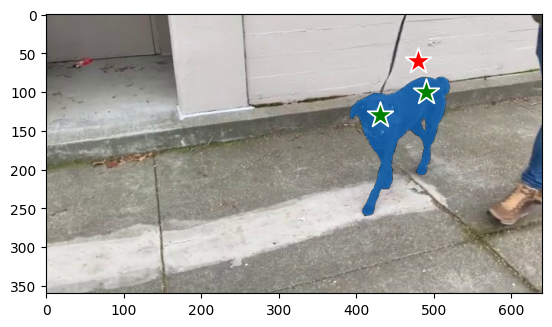

In [29]:
from image_helper import show_points, show_mask
import matplotlib.pyplot as plt
from PIL import Image

input_point = np.array([[430, 130], [490, 100], [480, 60]])
input_label = np.array([1, 1, 0])

out_obj_ids, out_mask_logits = segmenter_video.add_new_points_or_box(input_point, input_label)

frame_0 = Image.open(os.path.join(segmenter_video.work_dir_path, "0.jpg"))
plt.imshow(np.array(frame_0.convert("RGB")))
show_points(np.array(input_point), np.array(input_label), plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca())
plt.show()

In [30]:
res = segmenter_video.propagate_in_video()

propagate in video:   0%|          | 0/50 [00:00<?, ?it/s]

propagate in video: 100%|██████████| 50/50 [08:12<00:00,  9.85s/it]


In [31]:
video_out_path = segmenter_video.save_as_video("point_results.mp4")

In [32]:
import IPython

IPython.display.Video(filename=video_out_path, embed=True)

### Example with box
[back to top ⬆️](#Table-of-contents:)

In [ ]:
segmenter_video.set_video(sample_path / "coco.mp4")

frame loading (JPEG): 100%|█████████████████████| 50/50 [00:00<00:00, 55.02it/s]


PosixPath('data/coco.mp4')

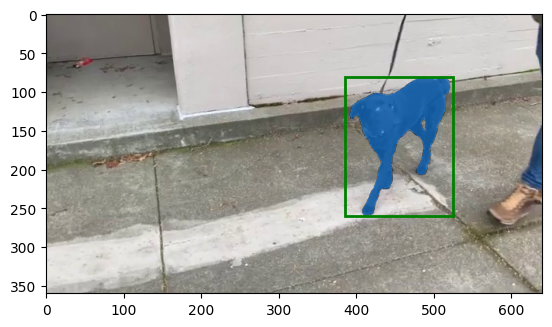

In [ ]:
from image_helper import show_box

input_box = np.array([385, 80, 525, 260])

out_obj_ids, out_mask_logits = segmenter_video.add_new_points_or_box(box=input_box)

frame_0 = Image.open(os.path.join(segmenter_video.work_dir_path, "0.jpg"))
plt.imshow(np.array(frame_0.convert("RGB")))
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca())
show_box(input_box, plt.gca())
plt.show()

In [ ]:
res = segmenter_video.propagate_in_video()

propagate in video: 100%|███████████████████████| 50/50 [01:50<00:00,  2.21s/it]


In [ ]:
video_out_path = segmenter_video.save_as_video("box_results.mp4")

In [ ]:
IPython.display.Video(filename=video_out_path, embed=True)

### Run Interactive For Video Segmentation with Gradio
[back to top ⬆️](#Table-of-contents:)

In [ ]:
if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/segment-anything/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_video_demo

segmenter = SegmenterVideo(ov_predictor_video)
demo = make_video_demo(segmenter, sample_path)

try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name="your server name", server_port="server port in int")`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/